In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [8]:
# Load dataset
df = pd.read_csv("/content/sample_data/online_retail_II.csv")  # UCI dataset usually in Excel format
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [13]:
# Remove missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove negative or cancelled orders
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Add Total Price column
df['TotalPrice'] = df['Quantity'] * df['Price']



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   Price        824364 non-null  float64
 6   Customer ID  824364 non-null  float64
 7   Country      824364 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 56.6+ MB


In [16]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [19]:
# Reference date = dataset's max InvoiceDate + 1 day
import datetime as dt
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Invoice': 'count',                                # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,34,77556.46
1,12347.0,2,253,5633.32
2,12348.0,75,51,2019.40
3,12349.0,19,175,4428.69
4,12350.0,310,17,334.40


In [20]:
# Scoring using quartiles (1–4)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Final RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,34,77556.46,2,2,4,224
1,12347.0,2,253,5633.32,4,4,4,444
2,12348.0,75,51,2019.40,3,2,3,323
3,12349.0,19,175,4428.69,4,4,4,444
4,12350.0,310,17,334.40,2,1,1,211


In [21]:
# Define simple segmentation rules
def segment(x):
    if x['R_Score'] in ['4'] and x['F_Score'] in ['4'] and x['M_Score'] in ['4']:
        return "Champions"
    elif x['R_Score'] in ['3','4'] and x['F_Score'] in ['3','4']:
        return "Loyal Customers"
    elif x['R_Score'] in ['4'] and x['F_Score'] in ['1','2']:
        return "New Customers"
    elif x['R_Score'] in ['1','2'] and x['F_Score'] in ['3','4']:
        return "At Risk"
    else:
        return "Others"

rfm['Segment'] = rfm.apply(segment, axis=1)
rfm['Segment'].value_counts()


,count
Segment,
Others,5878


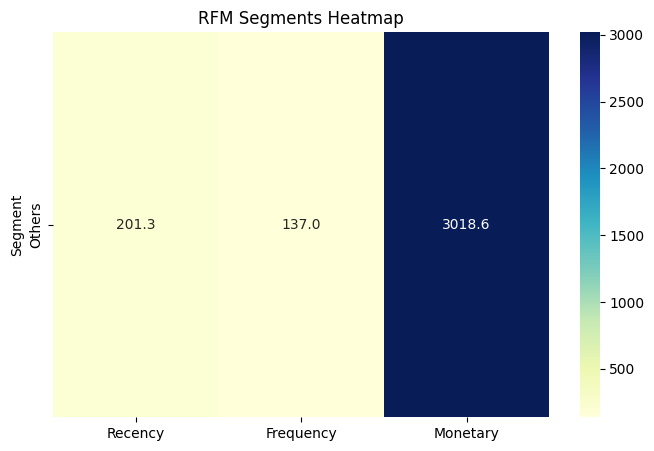

In [23]:
# Group only numeric columns
rfm_seg = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()

plt.figure(figsize=(8,5))
sns.heatmap(rfm_seg, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("RFM Segments Heatmap")
plt.show()



In [24]:
# Count customers per segment
segment_summary = rfm['Segment'].value_counts().reset_index()
segment_summary.columns = ['Segment','CustomerCount']
print(segment_summary)


  Segment  CustomerCount
0  Others           5878
